In [145]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import netwulf as nw
from scipy.optimize import minimize
import scipy as scp
from scipy.spatial import distance_matrix
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_theme()

**Functions used to simulate relations between labels**

In [131]:
#given "points" with labels a and b we can assign probability of an edge between them
def basic_func(a,b):
    if a == b:
        return .8
    else:
        return .2
    
def sparse_func(a,b):
    if a == b:
        return .01
    else:
        return .005
    
def medium_func(a,b):
    if a == b:
        return .15
    else:
        return .03

def basic_func2(a,b):
    if a == 1 and b == 1:
        return .8
    if a == 0 and b == 0:
        return .4
    else:
        return .2
def basic_func3(a,b):
    if a == b:
        return .01
    return np.abs(a-b)
def basic_func4(a,b):
    if a == b:
        return .01
    return (a-b)**2

**Creation of an CSBM**

In [3]:
def create_graph(num_nodes, labels, func):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, group=labels[i])
        for j in range(i):
            if func(labels[i], labels[j]) != func(labels[j],labels[i]):
                print("WARNING, asymetric function")
            if np.random.rand() < func(labels[i], labels[j]):
                G.add_edge(i, j)
    return G
def create_transition_matrix(labels, func):
    matrix = []
    for i in range(len(labels)):
        arr = []
        for j in range(len(labels)):
            if func(labels[i], labels[j]) != func(labels[j],labels[i]):
                print("WARNING, asymetric function")
            arr.append(func(labels[i], labels[j]))
        matrix.append(arr)
    return np.array(matrix)

**Useful functions**

In [46]:
#input is a numpy array of labels
def sigmoid(x):
     return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(x/(1-x))
def sigmoid_prime(x):
     return np.exp(x) / np.square(1 + np.exp(x))
def fit_matrix(labels):
    array = labels.T @ labels
    return sigmoid(array)
def matrix_log_likelihood(sample,X):
    sample_complement= 1-sample - np.identity(sample.shape[0])
    return np.sum(np.multiply(sample, np.log(X)) + np.multiply(sample_complement, np.log(1-X)))/sample.shape[0]**2
def log_likelihood(sample,labels, use_sigmoid=True):
    sample_complement= 1-sample - np.identity(sample.shape[0])
    #print("sample",sample)
    #print("compliment",sample_complement)
    if use_sigmoid:
        X = fit_matrix(labels)
    else:
        X = labels
    #print(X)
    log_errs = np.multiply(sample, np.log(X)) + np.multiply(sample_complement, np.log(1-X))
    #print(log_errs)
    return np.sum(log_errs)/sample.shape[0]**2

In [5]:
def projection_derivative(A, X):
    A_complement= 1-A - np.identity(A.shape[0])
    derivs = np.multiply(A, sigmoid(-X)) + np.multiply(A_complement, -sigmoid(X))
    return derivs

In [30]:
def projection_descent(A, step_size=.01, steps =100, params = 2):
    n = len(A)
    cur_matrix = np.zeros(shape=A.shape)
    likelihoods = []
    #print(cur_matrix.shape)
    for i in range(steps):
        for j in range(100):
            #print(projection_derivative(A, cur_matrix).shape)
            derivs = projection_derivative(A, cur_matrix)
            cur_matrix += derivs*step_size
        vals, vecs = scp.linalg.eig(cur_matrix)

        D = np.zeros(shape=(A.shape), dtype=float)
        D[:params, :params] = np.diag(vals.real)[:params,:params]
        cur_matrix = vecs@ D @vecs.T
        #print(cur_matrix.shape)
        likelihoods.append(matrix_log_likelihood(A, sigmoid(cur_matrix)))
        print(i, matrix_log_likelihood(A, sigmoid(cur_matrix)))
    return cur_matrix, likelihoods

In [24]:
def rank_d_approx(M, d):
    vals, vecs = scp.linalg.eig(M)

    D = np.zeros(shape=(M.shape), dtype=float)
    D[:d, :d] = np.diag(vals.real)[:d,:d]
    cur_matrix = vecs@ D @vecs.T
    return np.abs(cur_matrix)
def frob_dist(X,Y):
    return np.sum((X-Y)**2)/(len(X)*len(X[0]))

In [290]:
def rank_d_approx_complex(M, d):
    vals, vecs = scp.linalg.eig(M)

    D = np.zeros(shape=(M.shape), dtype=float)
    D[:d, :d] = np.diag(vals.real)[:d,:d]
    cur_matrix = vecs@ D @vecs.T
    return cur_matrix

In [7]:
def get_labels(A, num_labels=2):
    vals, vecs = scp.linalg.eig(A)
        
    D = np.zeros(shape=(A.shape), dtype=float)
    D[:num_labels, :num_labels] = np.diag(vals.real)[:num_labels,:num_labels]
    
    labels = []
    #print(vecs.T[1]*(D[1][1]))
    for i in range(num_labels):
        #print(D[i][i])
        labels.append(vecs.T[i]*np.sqrt(D.astype('complex128')[i][i]))
        #print(i)
    return np.array(labels)
    
    #matrix_log_likelihood(A, sigmoid(vecs@ D @ vecs.T))

# Simulated Datasets

In [246]:
n = 1000
labels = np.random.randint(2,size=n)
G = create_graph(n, labels, basic_func)
X = create_transition_matrix(labels, basic_func)
M = nx.to_numpy_array(G)

In [247]:
X

array([[0.8, 0.2, 0.8, ..., 0.8, 0.8, 0.2],
       [0.2, 0.8, 0.2, ..., 0.2, 0.2, 0.8],
       [0.8, 0.2, 0.8, ..., 0.8, 0.8, 0.2],
       ...,
       [0.8, 0.2, 0.8, ..., 0.8, 0.8, 0.2],
       [0.8, 0.2, 0.8, ..., 0.8, 0.8, 0.2],
       [0.2, 0.8, 0.2, ..., 0.2, 0.2, 0.8]])

In [248]:
rank_d_approx(M,2)

array([[0.80634747, 0.15937512, 0.81554149, ..., 0.7949883 , 0.78062868,
        0.19538251],
       [0.15937512, 0.79716766, 0.16222463, ..., 0.18364313, 0.18722748,
        0.76404721],
       [0.81554149, 0.16222463, 0.82484173, ..., 0.80408854, 0.78957385,
        0.19858833],
       ...,
       [0.7949883 , 0.18364313, 0.80408854, ..., 0.78470722, 0.77077229,
        0.21774996],
       [0.78062868, 0.18722748, 0.78957385, ..., 0.77077229, 0.75714694,
        0.22035557],
       [0.19538251, 0.76404721, 0.19858833, ..., 0.21774996, 0.22035557,
        0.73464922]])

In [249]:
frob_dist(rank_d_approx(M,2), X)

0.0006368059458460171

In [251]:
output, losses = projection_descent(M, step_size=.008, steps=50, params=2)

0 -0.6321067700662054
1 -0.5913986786404317
2 -0.5636524774543237
3 -0.5444943251298451
4 -0.5310879644579545
5 -0.5215865289519342
6 -0.5147740437570901
7 -0.5098386804019108
8 -0.5062304152296487
9 -0.5035712172824334
10 -0.5015977423467625
11 -0.5001242548012135
12 -0.4990182776075566
13 -0.49818436195628146
14 -0.4975531133191297
15 -0.497073670961234
16 -0.4967084891793362
17 -0.49642967375442304
18 -0.4962163828147589
19 -0.49605296497552603
20 -0.49592761385988277
21 -0.4958313880077041
22 -0.4957574917720423
23 -0.4957007442459376
24 -0.49565718472864295
25 -0.49562377805668534
26 -0.49559819345678396
27 -0.495578637851034
28 -0.49556372971089974
29 -0.49555240325638655
30 -0.49554383546683617
31 -0.4955373903104046
32 -0.49553257601898876
33 -0.49552901228029417
34 -0.49552640499210404
35 -0.4955245267991333
36 -0.495523202062863
37 -0.4955222952375654
38 -0.4955217018690089
39 -0.4955213416163748
40 -0.49552115283758275
41 -0.4955210883845697
42 -0.4955211123362488
43 -0.4955

Text(0.5, 1.0, 'Sim1 Log Loss over Time')

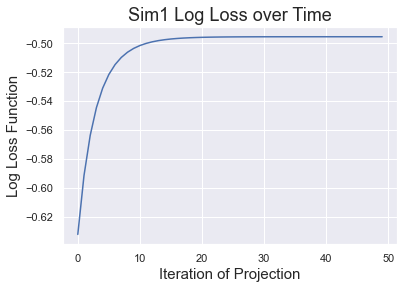

In [253]:
plt.plot(losses)
plt.xlabel('Iteration of Projection', fontsize=15)
plt.ylabel('Log Loss Function', fontsize=15)
plt.title('Sim1 Log Loss over Time', fontsize=18)

In [255]:
frob_dist(sigmoid(output), X)

0.00093460467813509

In [256]:
log_likelihood(M, rank_d_approx(M,2), use_sigmoid=False)

-0.4965200999981523

In [262]:
labels = np.abs(get_labels(sigmoid(output)))

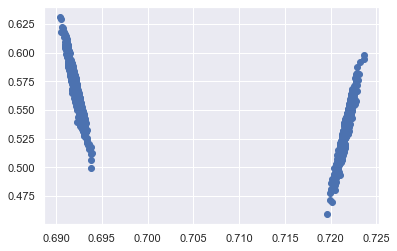

In [263]:
plt.scatter(labels[0],labels[1])

Text(0.5, 1.0, 'Sim1 Distribution of Labels')

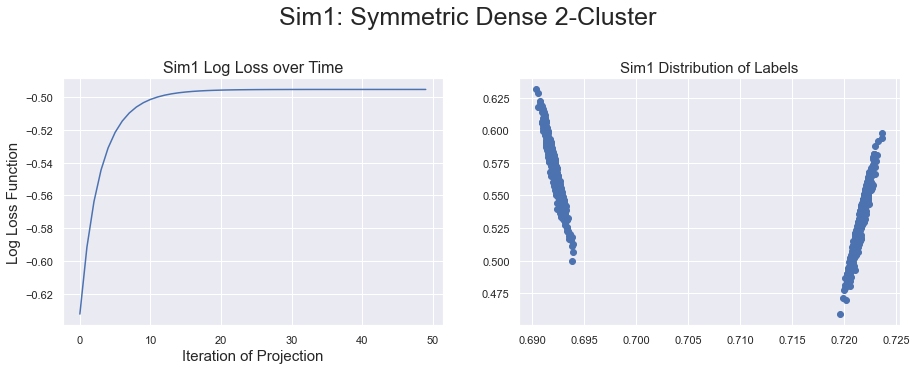

In [264]:
fig=plt.figure(figsize=(15,5))
fig.set_figheight(10)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
fig.suptitle('Sim1: Symmetric Dense 2-Cluster', fontsize=25)
ax1.plot(losses)
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Sim1 Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1])
ax2.set_title("Sim1 Distribution of Labels", fontsize=15)

## Dataset 2

In [302]:
n = 2000
labels = np.random.randint(2,size=n)
G = create_graph(n, labels, sparse_func)
X = create_transition_matrix(labels, sparse_func)
M = nx.to_numpy_array(G)

In [303]:
frob_dist(rank_d_approx(M,2), X)

2.263965272674751e-05

In [304]:
output, losses = projection_descent(M, step_size=.08, steps=50, params=2)

0 -0.14973904030739274
1 -0.08946541000354954
2 -0.06956752952116468
3 -0.06017936405282753
4 -0.054905320364167946
5 -0.051619009835776726
6 -0.04942576566957419
7 -0.04788880360589197
8 -0.046771740784067255
9 -0.04593658107575954
10 -0.045297945520243604
11 -0.04480052417766622
12 -0.044407125205504945
13 -0.04409195681779131
14 -0.04383666354328302
15 -0.04362789079405871
16 -0.04345573600130417
17 -0.04331273393227777
18 -0.04319317459128618
19 -0.04309263419898492
20 -0.0430076461681656
21 -0.04293546613866484
22 -0.042873901481679716
23 -0.042821185791942114
24 -0.04277588528589917
25 -0.04273682816322405
26 -0.042703050718437045
27 -0.04267375582130581
28 -0.04264828063418077
29 -0.04262607129939106
30 -0.04260666293685233
31 -0.042589663723447586
32 -0.04257474213595814
33 -0.04256161666483337
34 -0.04255004747168842
35 -0.042539829586186885
36 -0.04253078732979257
37 -0.04252276972312508
38 -0.042515646686294976
39 -0.042509305881903096
40 -0.042503650081468475
41 -0.04249859

Text(0.5, 1.0, 'Sim2 Log Loss over Time')

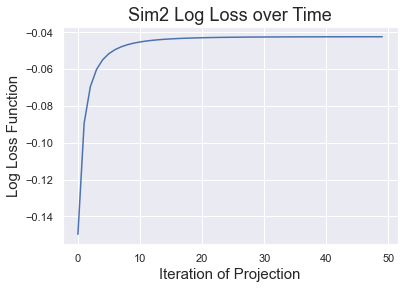

In [305]:
plt.plot(losses)
plt.xlabel('Iteration of Projection', fontsize=15)
plt.ylabel('Log Loss Function', fontsize=15)
plt.title('Sim2 Log Loss over Time', fontsize=18)

In [306]:
frob_dist(sigmoid(output), X)

1.1630783336196029e-05

In [307]:
labels = np.abs(get_labels(sigmoid(output)))

In [308]:
labels = np.real(get_labels(sigmoid(output)))+np.imag(get_labels(sigmoid(output)))

In [309]:
log_likelihood(M, rank_d_approx(M,2), use_sigmoid=False)

-0.04238910733359749

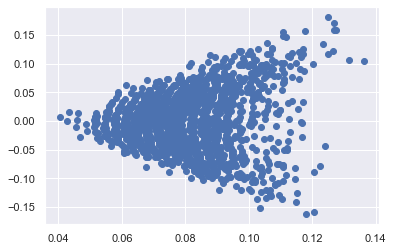

In [310]:
plt.scatter(labels[0],labels[1])

In [312]:
sigmoid(output)

array([[0.0158102 , 0.00792936, 0.00299727, ..., 0.00379298, 0.0059435 ,
        0.00208187],
       [0.00792936, 0.01240634, 0.00914657, ..., 0.01033391, 0.00638768,
        0.00758904],
       [0.00299727, 0.00914657, 0.00923882, ..., 0.00998569, 0.00353515,
        0.00822327],
       ...,
       [0.00379298, 0.01033391, 0.00998569, ..., 0.01084503, 0.00422819,
        0.00881939],
       [0.0059435 , 0.00638768, 0.00353515, ..., 0.00422819, 0.00350133,
        0.00268433],
       [0.00208187, 0.00758904, 0.00822327, ..., 0.00881939, 0.00268433,
        0.00741116]])

Text(0.5, 1.0, 'Sim2 Distribution of Labels')

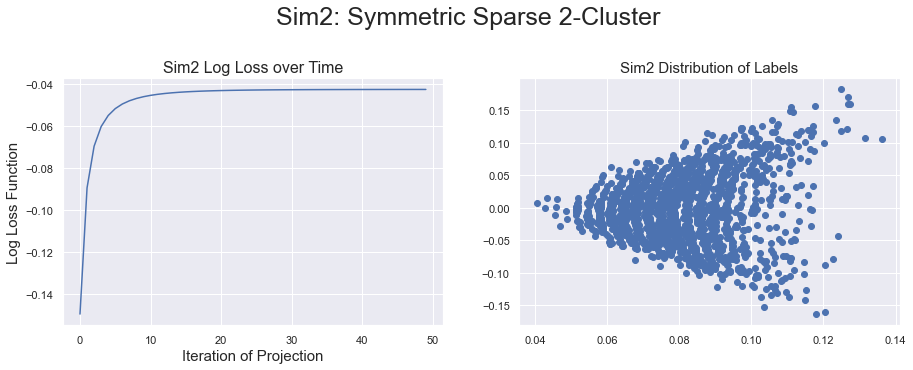

In [313]:
fig=plt.figure(figsize=(15,5))
fig.set_figheight(10)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
fig.suptitle('Sim2: Symmetric Sparse 2-Cluster', fontsize=25)
ax1.plot(losses)
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Sim2 Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1])
ax2.set_title("Sim2 Distribution of Labels", fontsize=15)

### Dataset 3

In [293]:
n = 1000
labels = np.random.randint(2,size=n)
G = create_graph(n, labels, medium_func)
X = create_transition_matrix(labels, medium_func)
M = nx.to_numpy_array(G)

In [294]:
frob_dist(rank_d_approx(M,2), X)

0.00033313118847571086

In [295]:
output, losses = projection_descent(M, step_size=.02, steps=50, params=2)

0 -0.473345101083383
1 -0.3840697949180632
2 -0.3420448653132668
3 -0.3197376238303845
4 -0.3067757070011985
5 -0.2987047413389221
6 -0.2933975231168945
7 -0.2897499598086476
8 -0.28714978117189294
9 -0.2852386729827909
10 -0.28379730632455685
11 -0.2826861755926643
12 -0.2818135318003378
13 -0.28111722460535227
14 -0.2805540275145724
15 -0.28009315396317847
16 -0.2797122033204801
17 -0.2793945593479191
18 -0.27912768067544513
19 -0.2789019526591602
20 -0.2787099005139614
21 -0.27854563978784935
22 -0.2784044857843943
23 -0.2782826713686399
24 -0.27817713994195453
25 -0.27808539139106037
26 -0.27800536593771874
27 -0.2779353554931441
28 -0.2778739352415336
29 -0.27781991028944736
30 -0.27777227366800494
31 -0.27773017298402497
32 -0.277692883727554
33 -0.2776597877508647
34 -0.277630355800543
35 -0.2776041332519604
36 -0.2775807283929804
37 -0.27755980275106423
38 -0.2775410630688295
39 -0.27752425461735214
40 -0.27750915560105444
41 -0.2774955724578622
42 -0.27748333589712265
43 -0.27

Text(0.5, 1.0, 'Sim3 Log Loss over Time')

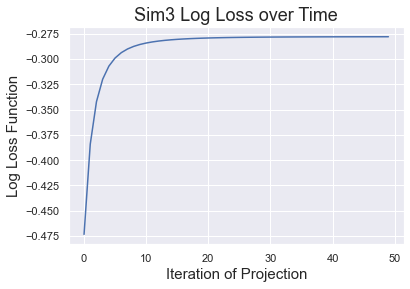

In [234]:
plt.plot(losses)
plt.xlabel('Iteration of Projection', fontsize=15)
plt.ylabel('Log Loss Function', fontsize=15)
plt.title('Sim3 Log Loss over Time', fontsize=18)

In [235]:
frob_dist(sigmoid(output), X)

0.0003135282013742871

In [236]:
log_likelihood(M, rank_d_approx(M,2), use_sigmoid=False)

-0.277899802267522

In [237]:
labels = np.abs(get_labels(sigmoid(output)))

In [299]:
labels = np.real(get_labels(sigmoid(output))) + np.imag(get_labels(sigmoid(output)))

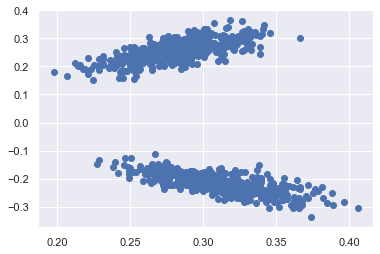

In [300]:
plt.scatter(labels[0],labels[1])

In [239]:
labels = np.abs(get_labels(rank_d_approx(M,2)))

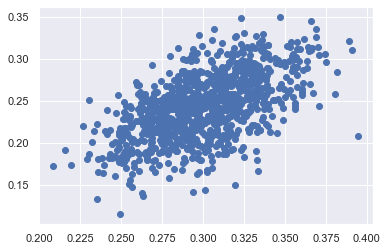

In [240]:
plt.scatter(labels[0],labels[1])

In [241]:
sigmoid(output)

array([[0.15205032, 0.12032133, 0.13247987, ..., 0.12874809, 0.03392519,
        0.03158508],
       [0.12032133, 0.10096663, 0.10948327, ..., 0.10439802, 0.04197086,
        0.04011613],
       [0.13247987, 0.10948327, 0.11911937, ..., 0.1143458 , 0.0410245 ,
        0.03892853],
       ...,
       [0.12874809, 0.10439802, 0.1143458 , ..., 0.10987274, 0.0351047 ,
        0.03309412],
       [0.03392519, 0.04197086, 0.0410245 , ..., 0.0351047 , 0.15384517,
        0.16777432],
       [0.03158508, 0.04011613, 0.03892853, ..., 0.03309412, 0.16777432,
        0.18411563]])

In [242]:
X

array([[0.15, 0.15, 0.15, ..., 0.15, 0.03, 0.03],
       [0.15, 0.15, 0.15, ..., 0.15, 0.03, 0.03],
       [0.15, 0.15, 0.15, ..., 0.15, 0.03, 0.03],
       ...,
       [0.15, 0.15, 0.15, ..., 0.15, 0.03, 0.03],
       [0.03, 0.03, 0.03, ..., 0.03, 0.15, 0.15],
       [0.03, 0.03, 0.03, ..., 0.03, 0.15, 0.15]])

In [243]:
rank_d_approx(M,2)

array([[0.15455496, 0.12421112, 0.13599462, ..., 0.13348696, 0.03198595,
        0.02928839],
       [0.12421112, 0.10109884, 0.11029531, ..., 0.1080308 , 0.03979776,
        0.03889518],
       [0.13599462, 0.11029531, 0.12044892, ..., 0.11804671, 0.03921085,
        0.03783092],
       ...,
       [0.13348696, 0.1080308 , 0.11804671, ..., 0.11573393, 0.03593591,
        0.03435228],
       [0.03198595, 0.03979776, 0.03921085, ..., 0.03593591, 0.16247007,
        0.1759065 ],
       [0.02928839, 0.03889518, 0.03783092, ..., 0.03435228, 0.1759065 ,
        0.19064667]])

Text(0.5, 1.0, 'Sim3 Distribution of Labels')

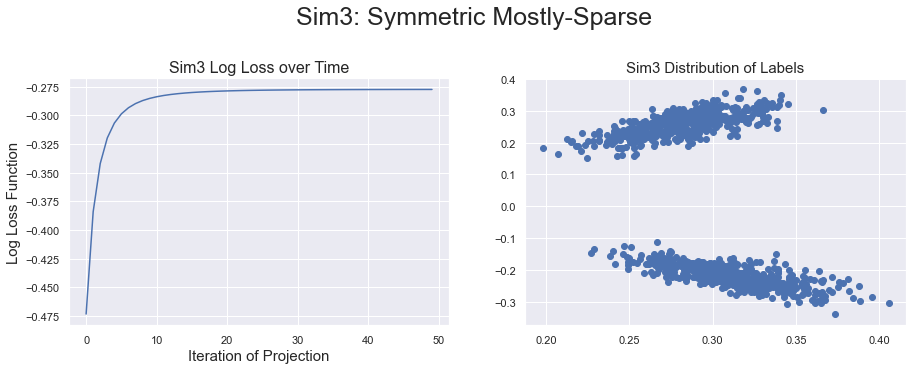

In [301]:
fig=plt.figure(figsize=(15,5))
fig.set_figheight(10)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
fig.suptitle('Sim3: Symmetric Mostly-Sparse', fontsize=25)
ax1.plot(losses)
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Sim3 Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1])
ax2.set_title("Sim3 Distribution of Labels", fontsize=15)

# Dataset 4

In [218]:
n = 1000
labels = np.random.randint(2,size=n)
G = create_graph(n, labels, basic_func2)
X = create_transition_matrix(labels, basic_func2)
M = nx.to_numpy_array(G)

In [219]:
frob_dist(rank_d_approx(M,2), X)

0.0007504012866971122

In [220]:
output, losses = projection_descent(M, step_size=.01, steps=30, params=2)

0 -0.6369748566745222
1 -0.6029598229516886
2 -0.5817555542167547
3 -0.5682780308344638
4 -0.5595494513559841
5 -0.5538007815486978
6 -0.5499594379946625
7 -0.5473609364139449
8 -0.5455850820527772
9 -0.5443611574184064
10 -0.5435118368835892
11 -0.5429192713457742
12 -0.542504145223081
13 -0.5422124915266928
14 -0.5420072441762628
15 -0.5418627394562151
16 -0.5417610862671385
17 -0.5416897398058178
18 -0.5416398615599275
19 -0.5416051998463103
20 -0.5415813190215149
21 -0.5415650647076466
22 -0.5415541902813017
23 -0.5415470944729245
24 -0.5415426360908704
25 -0.5415400026322147
26 -0.5415386167626075
27 -0.5415380695443986
28 -0.5415380726421591
29 -0.5415384240443079


Text(0.5, 1.0, 'Sim4 Log Loss over Time')

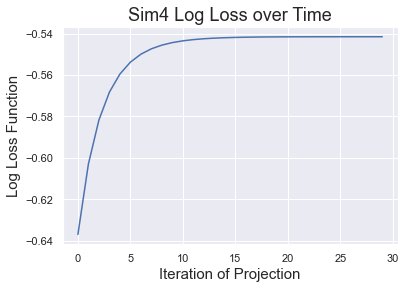

In [221]:
plt.plot(losses)
plt.xlabel('Iteration of Projection', fontsize=15)
plt.ylabel('Log Loss Function', fontsize=15)
plt.title('Sim4 Log Loss over Time', fontsize=18)

In [222]:
frob_dist(sigmoid(output), X)

0.0007298366056682454

In [223]:
log_likelihood(M, rank_d_approx(M,2), use_sigmoid=False)

-0.5415292704475854

In [224]:
labels = np.abs(get_labels(sigmoid(output)))

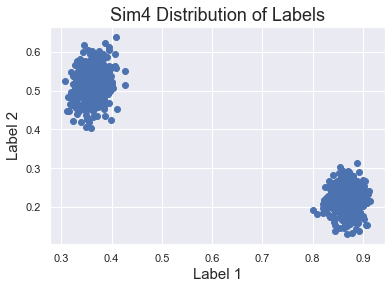

In [225]:
plt.title("Sim4 Distribution of Labels", fontsize=18)
plt.xlabel("Label 1", fontsize=15)
plt.ylabel("Label 2", fontsize=15)
plt.scatter(labels[0],labels[1])

Text(0.5, 1.0, 'Sim4 Distribution of Labels')

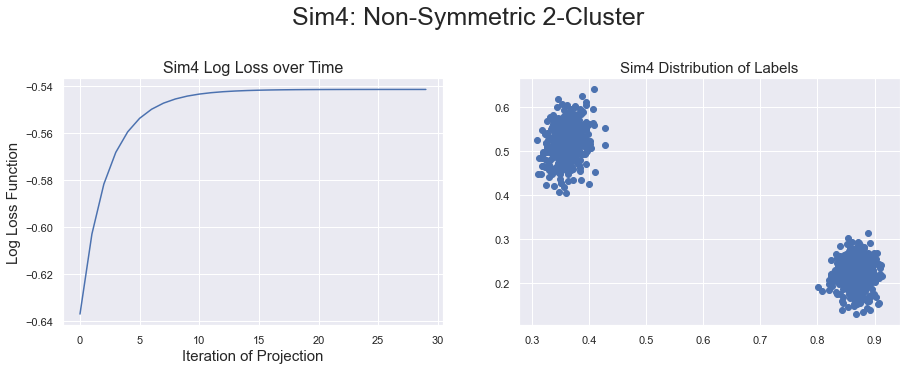

In [227]:
fig=plt.figure(figsize=(15,5))
fig.set_figheight(10)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
fig.suptitle('Sim4: Non-Symmetric 2-Cluster', fontsize=25)
ax1.plot(losses)
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Sim4 Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1])
ax2.set_title("Sim4 Distribution of Labels", fontsize=15)

# Dataset 5

In [275]:
n = 1000
labels = np.random.randint(3,size=n)
G = create_graph(n, labels, basic_func)
X = create_transition_matrix(labels, basic_func)
M = nx.to_numpy_array(G)

In [276]:
frob_dist(rank_d_approx(M,3), X)

0.0009383812042408723

In [277]:
output, losses = projection_descent(M, step_size=.01, steps=50, params=3)

0 -0.6208275376122393
1 -0.5768896276717514
2 -0.5494627013589082
3 -0.5319903276135818
4 -0.5206391199086206
5 -0.5131344219256405
6 -0.5080974526499814
7 -0.5046734427946902
8 -0.5023210110738936
9 -0.5006905373306515
10 -0.49955232087213164
11 -0.49875316222987487
12 -0.4981895441115123
13 -0.4977907285584696
14 -0.49750790757220414
15 -0.4973071243107032
16 -0.49716458660670204
17 -0.4970635239536577
18 -0.4969920554235264
19 -0.49694172872960735
20 -0.4969065102684915
21 -0.49688208147893376
22 -0.49686534526041704
23 -0.4968540776714802
24 -0.4968466808651186
25 -0.49684200704255826
26 -0.49683923252146456
27 -0.49683776735209967
28 -0.49683719026467166
29 -0.4968372017401381
30 -0.49683759009314615
31 -0.4968382069257135
32 -0.49683894934682343
33 -0.49683974708784867
34 -0.49684055316693465
35 -0.4968413371295736
36 -0.49684208016111275
37 -0.496842771560249
38 -0.496843406202195
39 -0.49684398272127445
40 -0.49684450221606674
41 -0.4968449673335592
42 -0.4968453816276075
43 -0

Text(0.5, 1.0, 'Sim5 Log Loss over Time')

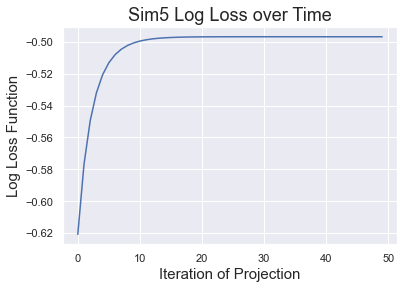

In [278]:
plt.plot(losses)
plt.xlabel('Iteration of Projection', fontsize=15)
plt.ylabel('Log Loss Function', fontsize=15)
plt.title('Sim5 Log Loss over Time', fontsize=18)

In [279]:
frob_dist(sigmoid(output), X)

0.0009520503304915019

In [280]:
log_likelihood(M, rank_d_approx(M,3), use_sigmoid=False)

-0.49686416511242126

In [281]:
labels = np.abs(get_labels(sigmoid(output), num_labels=3))

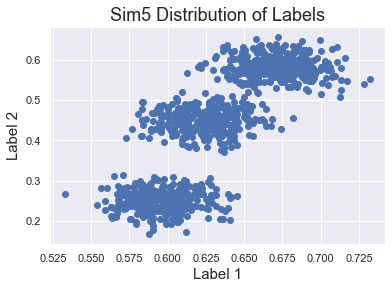

In [282]:
plt.title("Sim5 Distribution of Labels", fontsize=18)
plt.xlabel("Label 1", fontsize=15)
plt.ylabel("Label 2", fontsize=15)
plt.scatter(labels[0],labels[1])

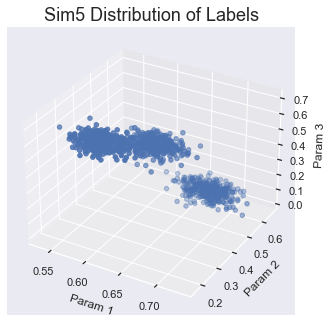

In [283]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(labels[0], labels[1], labels[2])
plt.title("Sim5 Distribution of Labels", fontsize=18)
ax.set_xlabel('Param 1', fontsize=12, rotation=150)
ax.set_ylabel('Param 2')
ax.set_zlabel('Param 3', fontsize=12, rotation=60)
plt.show()

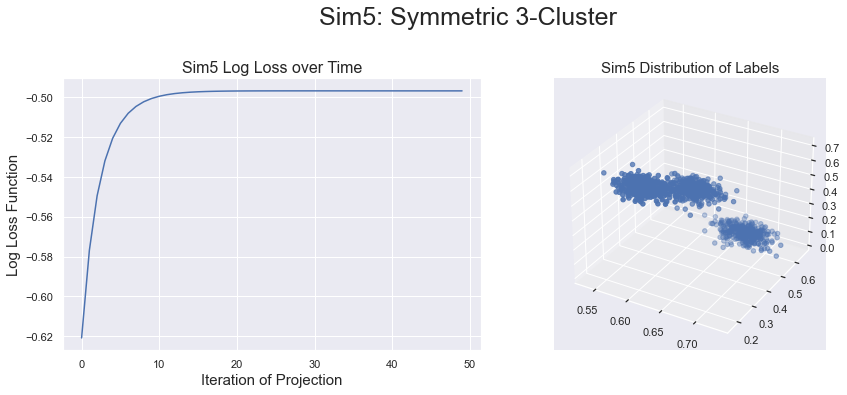

In [284]:
fig=plt.figure(figsize=(15,5))
fig.set_figheight(10)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2, projection='3d')
fig.suptitle('Sim5: Symmetric 3-Cluster', fontsize=25)
ax1.plot(losses)
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Sim5 Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1], labels[2])
ax2.set_title("Sim5 Distribution of Labels", fontsize=15)
#ax2.set_xlabel('Param 1', fontsize=12, rotation=150)
#ax2.set_ylabel('Param 2')
#ax2.set_zlabel('Param 3', fontsize=12, rotation=60)
fig.subplots_adjust(wspace=0, hspace=0)

In [ ]:
fig=plt.figure(figsize=(15,5))
fig.set_figheight(10)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2, projection='3d')
fig.suptitle('Sim5: Symmetric 3-Cluster', fontsize=25)
ax1.plot(losses)
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Sim5 Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1], labels[2])
ax2.set_title("Sim5 Distribution of Labels", fontsize=15)
#ax2.set_xlabel('Param 1', fontsize=12, rotation=150)
#ax2.set_ylabel('Param 2')
#ax2.set_zlabel('Param 3', fontsize=12, rotation=60)
fig.subplots_adjust(wspace=0, hspace=0)

# Dataset 6

In [315]:
n = 1000
labels = np.random.rand(n)
G = create_graph(n, labels, basic_func4)
X = create_transition_matrix(labels, basic_func4)
M = nx.to_numpy_array(G)

In [162]:
frob_dist(rank_d_approx(M,3), X)

0.000646332853495409

In [316]:
output, losses = projection_descent(M, step_size=.008, steps=100, params=3)

0 -0.5919266539391954
1 -0.5237590986503747
2 -0.47651162605194025
3 -0.4428902554900178
4 -0.41832810585496555
5 -0.39994107381352517
6 -0.3858712545745767
7 -0.37489319233134805
8 -0.36617895752929525
9 -0.3591562110418525
10 -0.35342073459352924
11 -0.34868132285091624
12 -0.3447242936537745
13 -0.34139015477827817
14 -0.33855796785624137
15 -0.33613468445785044
16 -0.33404775258433406
17 -0.33223990956596294
18 -0.33066545880594217
19 -0.329287568126123
20 -0.3280762814446183
21 -0.32700703555127825
22 -0.326059539521676
23 -0.32521691804137354
24 -0.3244650493126552
25 -0.3237920482123312
26 -0.32318785913626813
27 -0.32264393256501783
28 -0.3221529661636464
29 -0.32170869607717634
30 -0.32130572759357856
31 -0.32093939691801937
32 -0.3206056577069161
33 -0.32030098743566915
34 -0.3200223097505706
35 -0.31976692977571086
36 -0.31953247997573736
37 -0.31931687466285663
38 -0.3191182716162608
39 -0.318935039579956
40 -0.3187657306398693
41 -0.31860905666740885
42 -0.3184638691652268

Text(0.5, 1.0, 'Sim6 Log Loss over Time')

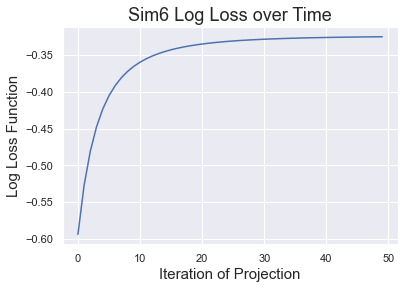

In [164]:
plt.plot(losses)
plt.xlabel('Iteration of Projection', fontsize=15)
plt.ylabel('Log Loss Function', fontsize=15)
plt.title('Sim6 Log Loss over Time', fontsize=18)

In [165]:
frob_dist(sigmoid(output), X)

0.0015392727244635642

In [166]:
labels = np.abs(get_labels(sigmoid(output), num_labels=3))

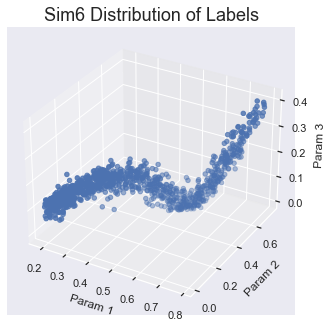

In [170]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(labels[0], labels[1], labels[2])
plt.title("Sim6 Distribution of Labels", fontsize=18)
ax.set_xlabel('Param 1', fontsize=12, rotation=150)
ax.set_ylabel('Param 2')
ax.set_zlabel('Param 3', fontsize=12, rotation=60)
plt.show()

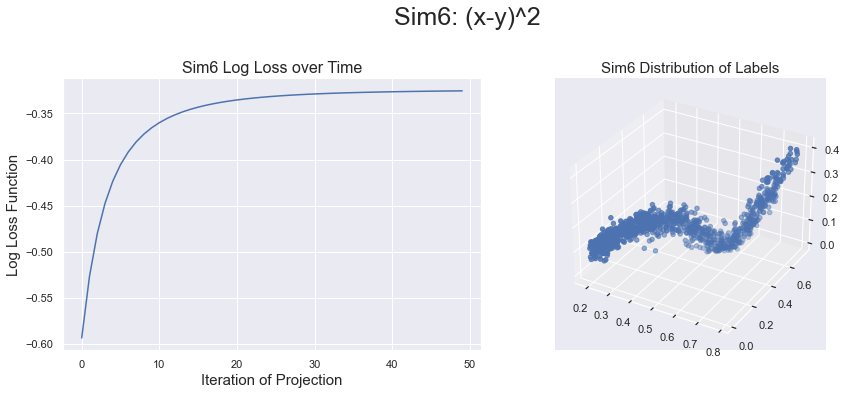

In [213]:
fig=plt.figure(figsize=(15,5))
fig.set_figheight(10)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2, projection='3d')
fig.suptitle('Sim6: (x-y)^2', fontsize=25)
ax1.plot(losses)
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Sim6 Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1], labels[2])
ax2.set_title("Sim6 Distribution of Labels", fontsize=15)
#ax2.set_xlabel('Param 1', fontsize=12, rotation=150)
#ax2.set_ylabel('Param 2')
#ax2.set_zlabel('Param 3', fontsize=12, rotation=60)
fig.subplots_adjust(wspace=0, hspace=0)

Text(0.5, 1.0, 'Sim6 Distribution of Labels')

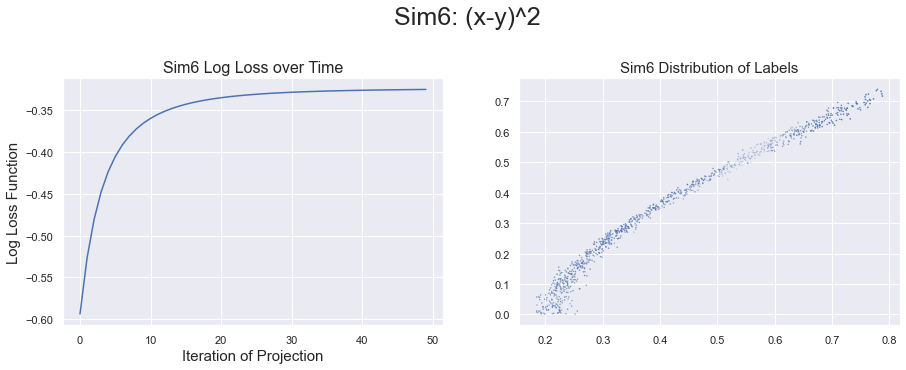

In [217]:
fig=plt.figure(figsize=(15,5))
fig.set_figheight(10)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
fig.suptitle('Sim6: (x-y)^2', fontsize=25)
ax1.plot(losses)
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Sim6 Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1], labels[2])
ax2.set_title("Sim6 Distribution of Labels", fontsize=15)
#ax2.set_xlabel('Param 1', fontsize=12, rotation=150)
#ax2.set_ylabel('Param 2')
#ax2.set_zlabel('Param 3', fontsize=12, rotation=60)
#fig.subplots_adjust(wspace=0, hspace=100)

In [291]:
rank_d_approx_complex(output, 2)

array([[ 1.97134575+0.j, -1.15257725+0.j,  2.20074034+0.j, ...,
        -0.98995922+0.j, -1.06041358+0.j, -1.05151492+0.j],
       [-1.15257725+0.j,  2.03281013+0.j, -1.15692748+0.j, ...,
        -0.8412321 +0.j,  2.12538491+0.j, -0.7976742 +0.j],
       [ 2.20074034+0.j, -1.15692748+0.j,  2.46922028+0.j, ...,
        -1.2407576 +0.j, -1.04005338+0.j, -1.30875347+0.j],
       ...,
       [-0.98995922+0.j, -0.8412321 +0.j, -1.2407576 +0.j, ...,
         1.98099348+0.j, -1.04055782+0.j,  2.00399653+0.j],
       [-1.06041358+0.j,  2.12538491+0.j, -1.04005338+0.j, ...,
        -1.04055782+0.j,  2.2380532 +0.j, -0.99906206+0.j],
       [-1.05151492+0.j, -0.7976742 +0.j, -1.30875347+0.j, ...,
         2.00399653+0.j, -0.99906206+0.j,  2.02896382+0.j]])